In [2]:
import numpy as np
import pandas as pd
from epiweeks import Week
from prophet import Prophet
import matplotlib.pyplot as plt
from epiweeks import Week

# Creating a simple forecasting model

Here we will create a simple forecasting model using the `prophet` library.

## Downloading the Dengue dataset

We will build a simple univariate model using only dengue cases. To fetch the data directly from the API, we'll use the Mosqlient library.

Our analysis will use data on Distrito Federal (DF).

In [3]:
start_date = str(Week(2023, 40).startdate())
end_date = str(Week(2024, 23).startdate())
start_date, end_date

('2023-10-01', '2024-06-02')

The code below is used since my api_key is saved on an .env file: 

In [6]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Access the environment variables
api_key = os.getenv('API_KEY')

In [11]:
df = pd.read_csv('dengue.csv.gz')

df = df.loc[df.uf == 'MG']

df['date'] = [Week.fromstring(str(x)).startdate() for x in df.epiweek]

df['date'] = pd.to_datetime(df['date'])

df.set_index('date', inplace = True)

df.head()

,year,epiweek,casos,geocode,regional,regional_geocode,macroregional,macroregional_geocode,uf,train_1,train_2,target_1,target_2
date,,,,,,,,,,,,,
2010-01-03,2010,201001,0,3110806,Itambacuri,31096,Nordeste,3111,MG,True,True,False,False
2010-01-03,2010,201001,0,3132404,Itajubá,31003,Sul,3101,MG,True,True,False,False
2010-01-03,2010,201001,0,3168903,São Gotardo,31082,Noroeste,3109,MG,True,True,False,False
2010-01-03,2010,201001,0,3155405,Juiz de Fora,31097,Sudeste,3107,MG,True,True,False,False
2010-01-03,2010,201001,0,3170602,Piumhi,31093,Sul,3101,MG,True,True,False,False


In [20]:
from mosqlient import get_infodengue

df = get_infodengue(
    api_key = api_key,
    disease = 'dengue',
    uf = 'DF',
    start_date = '2010-01-01',
    end_date = end_date)

#select columns and rename the `casprov` column.
columns = ['data_iniSE', 'SE', 'municipio_geocodigo', 'casprov', 'Rt', 'p_rt1']

df = df[columns].rename(columns = {'casprov':'casos', 'data_iniSE':'date'})

df['date'] = pd.to_datetime(df['date'])

df = df.sort_values(by = 'date')

df.head()

100%|██████████| 2/2 [00:08<00:00,  4.44s/requests]


,date,SE,municipio_geocodigo,casos,Rt,p_rt1
752,2010-01-03,201001,5300108,147.0,0.0,0.0
751,2010-01-10,201002,5300108,275.0,0.0,0.0
750,2010-01-17,201003,5300108,356.0,0.0,0.0
749,2010-01-24,201004,5300108,461.0,0.0,0.0
748,2010-01-31,201005,5300108,574.0,0.0,0.0


Let's prepare the dataset, renaming the columns to match the `prophet` library requirements. The library requires a `ds` column for the date and a `y` column for the value to be predicted. 

In [21]:
df = df.set_index('date')[['casos']].resample('W').sum().reset_index()

df = df.rename(columns = {'casos': 'y', 'date': 'ds'})

df.head()

,ds,y
0,2010-01-03,147.0
1,2010-01-10,275.0
2,2010-01-17,356.0
3,2010-01-24,461.0
4,2010-01-31,574.0


To ensure data is always positive and at the same scale, we will use the log of the number of cases. 

In [22]:
df_train = df.loc[df.ds <= start_date][['ds', 'y']]

df_train['y'] = np.log1p(df_train['y'])

df_train.head()

,ds,y
0,2010-01-03,4.997212
1,2010-01-10,5.620401
2,2010-01-17,5.877736
3,2010-01-24,6.135565
4,2010-01-31,6.354370


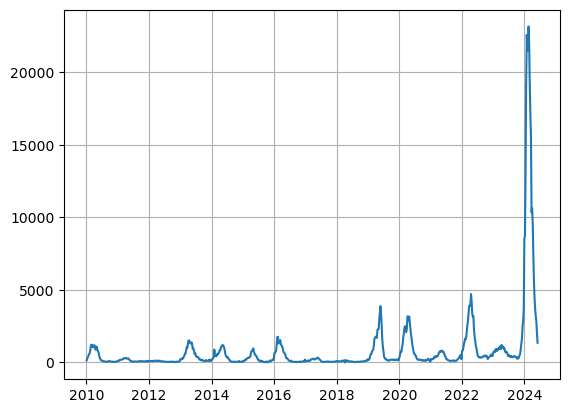

In [23]:
# Plot the training data
_, ax = plt.subplots()

ax.plot(df.ds, df.y, label = 'Casos')
ax.grid()
plt.show()

Let's define and train the model:

In [24]:
# Initialize and fit the model
model = Prophet(weekly_seasonality=True, yearly_seasonality=True, daily_seasonality=False, mcmc_samples = 100)
model.fit(df_train)

22:31:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

22:32:03 - cmdstanpy - INFO - CmdStan done processing.
22:32:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to l

## Making in-sample predictions

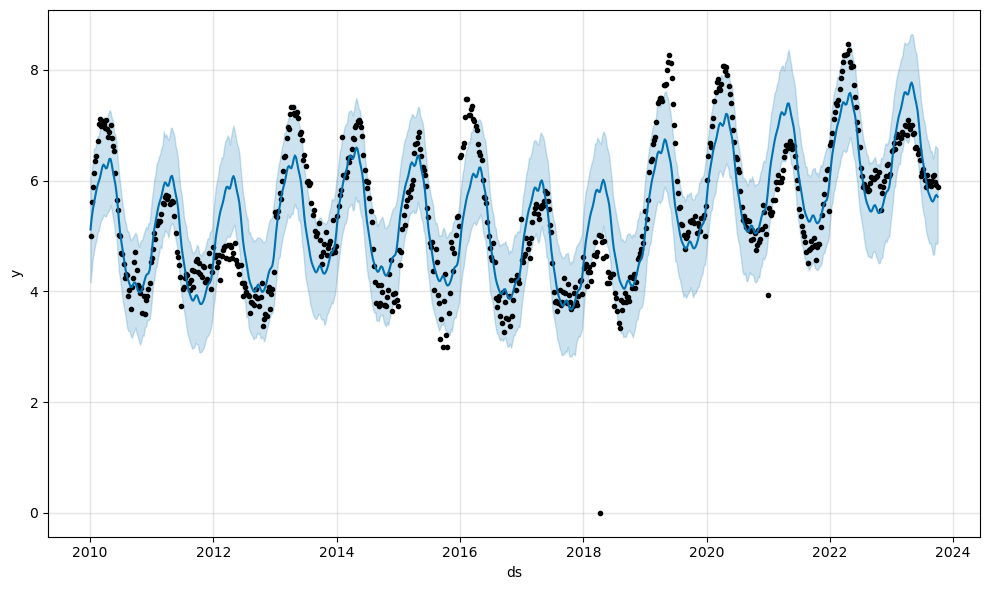

In [25]:
# Create a dataframe to hold predictions
dates = model.make_future_dataframe(periods=52, freq='W')
in_sample = dates[dates['ds'] <= start_date]

# Make predictions
forecast = model.predict(in_sample)
# Plot the forecast
fig1 = model.plot(forecast)

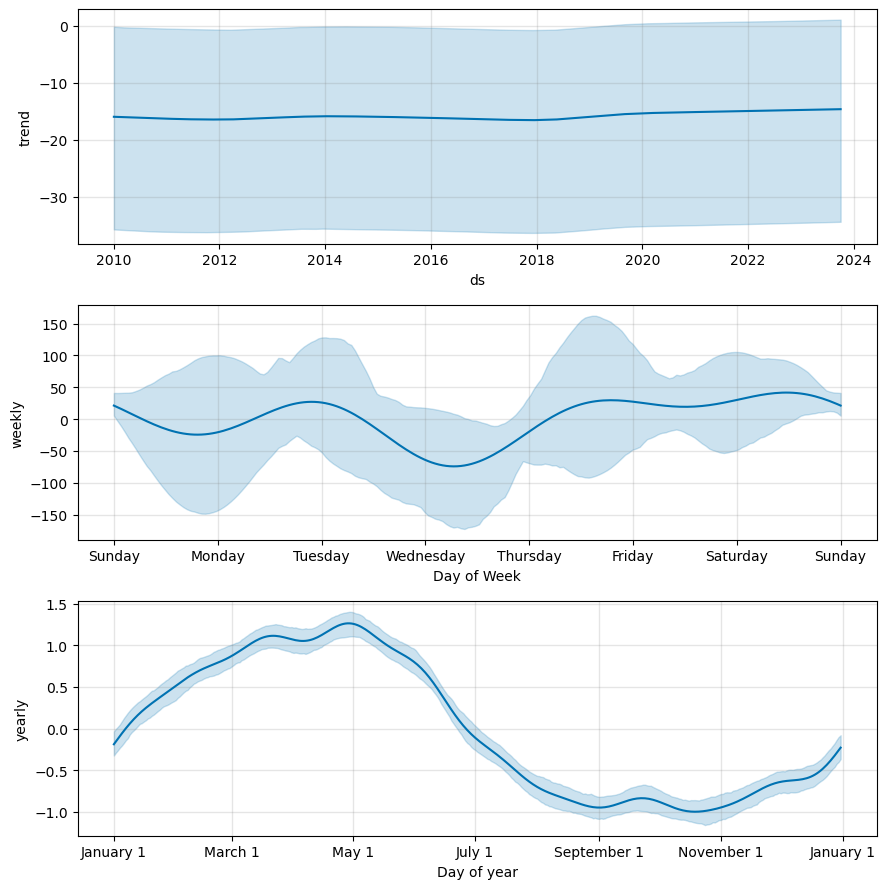

In [ ]:
# plot the forecast components
fig2 = model.plot_components(forecast)

## Using the model for forecasting:

In [27]:
# Create a dataframe to hold predictions
future = dates[dates['ds'] > start_date]
samples = model.predictive_samples(future)
yhat_samples = samples['yhat']

In [28]:
# Creating dataframe with the forecasted values and confidence intervals in the format required by the sprint   
np.percentile(yhat_samples, [2.5, 5, 10, 25, 50, 75, 90, 95, 97.5], axis=1).T.shape
for_data = np.expm1(np.percentile(yhat_samples, [2.5, 5, 10, 25, 50, 75, 90, 95, 97.5], axis=1).T)

df_forecast = pd.DataFrame(for_data, columns = ['lower_95', 'lower_90', 'lower_80', 'lower_50',
                                  'pred', 'upper_50', 'upper_80', 'upper_90', 'upper_95'])

df_forecast['date'] =  pd.to_datetime(np.array(future['ds']))

df_forecast.head()

,lower_95,lower_90,lower_80,lower_50,pred,upper_50,upper_80,upper_90,upper_95,date
0,73.877600,94.159361,116.512362,178.583741,282.815981,453.127139,648.803702,840.224816,1041.857956,2023-10-08
1,73.326040,87.605052,109.712481,164.021668,274.203779,451.939514,667.123002,890.356051,1028.165248,2023-10-15
2,69.627442,84.126553,105.195428,161.802203,262.894067,421.106168,669.537369,866.550397,1182.935399,2023-10-22
3,65.398079,82.566005,111.118402,173.420180,278.128049,452.098188,679.964104,896.146795,1059.824059,2023-10-29
4,67.768445,97.250643,119.593279,181.462235,286.100693,459.742960,724.178238,907.883747,1117.227870,2023-11-05


## Uploading the forecasts to the Mosqlimate platform


### 1. Upload your model. If you have done this already, you can skip to step 2.

In [29]:
from mosqlient import upload_model

name = "2025 sprint test - Prophet DF"
description = "test model for 2025 sprint test model for 2025 sprint test model for 2025 sprint test model for 2025 sprint"
repository = "https://github.com/Mosqlimate-project/sprint-template-2025/"
implementation_language = "Python"
disease = "dengue"
temporal = True
spatial = True
categorical = False
adm_level = 1
time_resolution = "week"
sprint = True

model = upload_model(
    api_key=api_key,
    name=name,
    description=description,
    repository=repository,
    implementation_language=implementation_language,
    disease=disease,
    temporal=temporal,
    spatial=spatial,
    categorical=categorical,
    adm_level=adm_level,
    time_resolution=time_resolution,
    sprint=sprint
)
model.dict()

{'id': 68,
 'name': '2025 sprint test - Prophet DF',
 'description': 'test model for 2025 sprint test model for 2025 sprint test model for 2025 sprint test model for 2025 sprint',
 'author': {'user': {'name': 'Zuilho Segundo', 'username': 'ZuilhoSe'},
  'institution': None},
 'repository': 'https://github.com/Mosqlimate-project/sprint-template-2025/',
 'implementation_language': {'language': 'Python'},
 'disease': 'dengue',
 'categorical': False,
 'spatial': True,
 'temporal': True,
 'ADM_level': 1,
 'time_resolution': 'week',
 'sprint': True}

If it worked correctly, you should be able to see the model in the Mosqlimate platform, under your "Models" tab:

![image](../model_creation.png)

### 2. Upload the predictions.

You can now upload the forecast using the function `upload_predictions` from the `mosqlient` package. 


The function has the following parameters:

- `model_id`: int, The id number of the model registered on the platform. 
- `description`: str, A brief description of the prediction. 
- `commit`": str, The commit number associated with the model that generated the prediction.
- `predict_date`: str, The day of the prediction. 
- `prediction`: pd.DataFrame, A  dataframe that contains the data. It must contain the following columns: [`date`, `lower_95`, `upper_95`, `lower_90`, `upper_90`, `lower_80`, `upper_80`, `lower_50`, `upper_50`, `preds`, `adm_{adm_level}`].
- `api_key`: str, your personal api key. 

When registering your model, you need to provide the `ADM Level` of the output predictions. If your model has an ADM level—1, state level, then your predictions must contain the `adm_1` column. The other adm columns can be set as NA values.

Let's add the adm level in out predictions.:

In [30]:
df_forecast['adm_1'] = 'DF'

df_forecast.head()

,lower_95,lower_90,lower_80,lower_50,pred,upper_50,upper_80,upper_90,upper_95,date,adm_1
0,73.877600,94.159361,116.512362,178.583741,282.815981,453.127139,648.803702,840.224816,1041.857956,2023-10-08,DF
1,73.326040,87.605052,109.712481,164.021668,274.203779,451.939514,667.123002,890.356051,1028.165248,2023-10-15,DF
2,69.627442,84.126553,105.195428,161.802203,262.894067,421.106168,669.537369,866.550397,1182.935399,2023-10-22,DF
3,65.398079,82.566005,111.118402,173.420180,278.128049,452.098188,679.964104,896.146795,1059.824059,2023-10-29,DF
4,67.768445,97.250643,119.593279,181.462235,286.100693,459.742960,724.178238,907.883747,1117.227870,2023-11-05,DF


To transform a dataframe in the json string format accepted by the function, just use the command: 

df_for.to_json(orient = 'records', date_format = 'iso')`. 

In [31]:
from mosqlient import upload_prediction

res = upload_prediction(
            model_id = 68, 
            description = 'test for sprint 2025 preds of the Prophet model in DF', 
            commit = 'df1c695eaa5af5edb125a9d4ec72a4d2528c7411',
            predict_date = '2025-04-24', 
            prediction = df_forecast,
            adm_1="DF",
            api_key = api_key)

If the prediction's upload worked will see it in your [predictions page](https://api.mosqlimate.org/predictions/):

![image](../predictions_upload.png)

The `mosqlient` package also contains a Class to compare your predictions called `Scorer`. A full documentation of the functions of this class can be found [here](https://github.com/Mosqlimate-project/mosqlimate-client/blob/main/docs/tutorials/scoring.ipynb). 

But in summary it takes as input the parameters: 
* `df_true`: pd.DataFrame. DataFrame with the columns `date` and `casos`. 
* `ids`: list[int] | None. List of the predictions already registered in the platform that you want to compare your model with. 
* `preds`: pd.DataFrame. Preds to be compared with df_true. It must contains the columns: `date`, `lower_95`, `upper_95`, `lower_90`, `upper_90`, `lower_80`, `upper_80`, `lower_50`, `upper_50`, `preds`, `adm_{adm_level}`.
  
Let's compare the `df_for` with what happened during the period. 

In [32]:
df_true = df.loc[(df.ds >= '2024-01-07') & (df.ds <= '2024-01-28')].rename(columns = {'y':'casos'})

# rename ds to date
df_true = df_true.rename(columns = {'ds':'date'})

df_true

,date,casos
731,2024-01-07,8713.0
732,2024-01-14,13135.0
733,2024-01-21,19232.0
734,2024-01-28,22583.0


In [33]:
df_forecast.dtypes

lower_95           float64
lower_90           float64
lower_80           float64
lower_50           float64
pred               float64
upper_50           float64
upper_80           float64
upper_90           float64
upper_95           float64
date        datetime64[ns]
adm_1               object
dtype: object

In [34]:
from mosqlient.scoring import Scorer

score = Scorer(api_key=api_key, df_true = df_true, pred = df_forecast, conf_level=0.90)

Let's see a plot comparing the cases and predictions:

In [35]:
score.plot_predictions()

alt.LayerChart(...)

Let's see the CRPS score of the model: 

In [36]:
score.crps

({'pred': date
  2024-01-07     7388.934695
  2024-01-14    11489.558798
  2024-01-21    17379.879704
  2024-01-28    20476.788748
  dtype: float64},
 {'pred': 14183.790486396425})

In [37]:
score.plot_crps()

alt.VConcatChart(...)